# Day Ahead Price Forecasting
Author: George Panagiotou

In [2]:
import pandas as pd
import numpy as np
from comp_utils import *
import lightgbm as lgb
import os
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
import os
import lightgbm as lgb
import optuna
from sklearn.metrics import make_scorer
import numpy as np

## Load Train data:

In [3]:
Actual=pd.read_csv('data/TradingTrackData/Actual_quantiles_cv_set.csv')
Actual['time']=pd.to_datetime(Actual['time'])
Actual.rename(columns={'time':'valid_time'},inplace=True)

In [6]:
train_weather_feat = pd.read_hdf('data/DAP/train_features.h5', 'df')
columns_to_drop = [
    'SS_Price', 'DA_Price', 'total_generation_MWh', 'ND', 'TSD', 
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION', 
    'EMBEDDED_SOLAR_CAPACITY', 'EMBEDDED_WIND_CAPACITY', 
    'PUMP_STORAGE_PUMPING', 'q10', 'q20', 'q30', 
    'q40', 'q50', 'q60', 'q70', 'q80', 'q90'
]
train_weather_feat = train_weather_feat.drop(columns=columns_to_drop)

demand_pred = pd.read_csv('data/TradingTrackData/Demand_quantiles_train_set.csv')
demand_pred.rename(columns={'time': 'valid_time'}, inplace=True)
demand_pred['valid_time'] = pd.to_datetime(demand_pred['valid_time'], utc=True)
demand_pred.drop(['ND'], axis=1, inplace=True)

energy_data = pd.read_hdf("data/combined/train_energy_data_20200920_20240519.h5", 'df')
train_table = pd.merge(demand_pred, train_weather_feat, on='valid_time', how='left')
train_table = pd.merge(train_table, energy_data, left_on='valid_time', right_on='dtm', how='left')
train_table.dropna(inplace=True)

# Define train_target_variable
train_target_variable = train_table['DA_Price']
# Apply IQR method to remove outliers from train_target_variable (DA_Price)
Q1 = train_target_variable.quantile(0.25)
Q3 = train_target_variable.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset to remove rows with outliers in 'DA_Price'
train_table = train_table[(train_target_variable >= lower_bound) & (train_target_variable <= upper_bound)]

# Drop unnecessary columns after filtering
train_times = train_table['valid_time']
# Define train_target_variable
train_target_variable = train_table['DA_Price']
train_table.drop(['DA_Price', 'dtm', 'MIP', 'Solar_installedcapacity_mwp', 'Solar_MW', 
                  'Solar_capacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh', 
                  'Availability1', 'Availability2', 'Availability3'], axis=1, inplace=True)

# Print the shape of the filtered dataset
print("Filtered Train Table Shape:", train_table.shape)

Filtered Train Table Shape: (50891, 81)


In [7]:
train_weather_feat = pd.read_hdf('data/DAP/train_features.h5', 'df')
columns_to_drop = [
    'SS_Price', 'DA_Price', 'total_generation_MWh', 'ND', 'TSD', 
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION', 
    'EMBEDDED_SOLAR_CAPACITY', 'EMBEDDED_WIND_CAPACITY', 
    'PUMP_STORAGE_PUMPING', 'q10', 'q20', 'q30', 
    'q40', 'q50', 'q60', 'q70', 'q80', 'q90'
]
train_weather_feat = train_weather_feat.drop(columns=columns_to_drop)

demand_pred=pd.read_csv('data/TradingTrackData/Demand_quantiles_cv_set.csv')
demand_pred.rename(columns={'time':'valid_time'}, inplace=True)
demand_pred['valid_time'] = pd.to_datetime(demand_pred['valid_time'], utc=True)
demand_pred.drop(['ND'], axis=1, inplace=True)

energy_data = pd.read_hdf("data/combined/train_energy_data_20200920_20240519.h5",'df')
cv_table = pd.merge(demand_pred, train_weather_feat, on='valid_time', how='left')
cv_table = pd.merge(cv_table, energy_data, left_on='valid_time', right_on='dtm', how='left')
cv_table.dropna(inplace=True)

cv_times = cv_table['valid_time']
cv_target_variable = cv_table['DA_Price']
cv_table.drop(['DA_Price','dtm', 'MIP', 'Solar_installedcapacity_mwp', 'Solar_MW', 'Solar_capacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh', 'Availability1', 'Availability2', 'Availability3',], axis=1, inplace=True)
print(cv_table.shape)
print("CV Set Shape:", cv_table.shape)

(5951, 81)
CV Set Shape: (5951, 81)


## Load Test data:

In [8]:
test_weather_feat = pd.read_hdf('data/DAP/test_features.h5', 'df')
columns_to_drop = [
    'SS_Price', 'DA_Price', 'total_generation_MWh', 'ND', 'TSD', 
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_SOLAR_GENERATION', 
    'EMBEDDED_SOLAR_CAPACITY', 'EMBEDDED_WIND_CAPACITY', 
    'PUMP_STORAGE_PUMPING', 'q10', 'q20', 'q30', 
    'q40', 'q50', 'q60', 'q70', 'q80', 'q90'
]
test_weather_feat = test_weather_feat.drop(columns=columns_to_drop)

demand_pred_test = pd.read_csv('data/Demand/Demand_predictions_test_set.csv')
demand_pred_test.rename(columns={'time':'valid_time'}, inplace=True)
demand_pred_test['valid_time'] = pd.to_datetime(demand_pred_test['valid_time'], utc=True)
demand_pred_test.drop(['ND'], axis=1, inplace=True)
print(demand_pred_test.shape)

energy_data_test = pd.read_hdf("data/combined/test_energy_data_20200920_20240519.h5",'df')

test_table = pd.merge(demand_pred_test, test_weather_feat, on='valid_time', how='left')
test_table = pd.merge(test_table, energy_data_test, left_on='valid_time', right_on='dtm', how='left')
test_table.fillna(test_table.mean(), inplace=True)

test_times = test_table['valid_time']
test_target_variable = test_table['DA_Price']
test_table.drop(['DA_Price','dtm', 'MIP', 'Solar_installedcapacity_mwp', 'Solar_MW', 'Solar_capacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh', 'Availability1', 'Availability2', 'Availability3',], axis=1, inplace=True)
print(test_table.shape)


(4318, 10)
(4318, 81)


## Transforming time into cyclic features:
We need to transform UTC datetime feature into numbers, thus we choose to convert datetime to cyclic features 

In [9]:
train_table = add_cyclic_features(train_table)
train_table = train_table.drop(columns=["valid_time"])
print('Train features after adding cyclic times and removing valid_time:', train_table.shape)

cv_table = add_cyclic_features(cv_table)
cv_table = cv_table.drop(columns=["valid_time"])
print('CV features after adding cyclic times and removing valid_time:', cv_table.shape)

test_table = add_cyclic_features(test_table)
test_table = test_table.drop(columns=["valid_time"])
print('Test features after adding cyclic times and removing valid_time:', test_table.shape)

Train features after adding cyclic times and removing valid_time: (50891, 89)
CV features after adding cyclic times and removing valid_time: (5951, 89)
Test features after adding cyclic times and removing valid_time: (4318, 89)


In [22]:
# Directory for saving models
saved_models_dir = 'models/DAP'
os.makedirs(saved_models_dir, exist_ok=True)

# Quantiles for the models
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_params_dict = {}
best_models = {}

# Function to compute pinball loss
def pinball_loss(y_true, y_pred, alpha):
    residuals = y_true - y_pred
    return np.mean(np.maximum(alpha * residuals, (alpha - 1) * residuals))

# Objective function for Optuna
def objective(trial, quantile, initial_params=None):
    if initial_params:
        params = initial_params
    else:
        params = {
            'objective': 'quantile',
            'alpha': quantile,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            'max_depth': trial.suggest_int('max_depth', -7, 7),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 1e3, log=True),
            'verbose': -1
        }

    model = lgb.LGBMRegressor(**params)

    # Train on train_table and evaluate on cv_table
    model.fit(train_table, train_target_variable)
    preds = model.predict(cv_table)
    
    # Calculate pinball loss on the CV set
    loss = pinball_loss(cv_target_variable, preds, alpha=quantile)
    
    return loss

# Train a model for each quantile with Optuna
for quantile in quantiles:
    print(f"Starting optimization for quantile {quantile}")
    study = optuna.create_study(direction='minimize')
    
    # Initial parameters (from the ones you provided)
    initial_params = {
        'objective': 'quantile',
        'alpha': quantile,
        'learning_rate': 0.1,
        'max_depth': -4,
        'n_estimators': 150,
        'num_leaves': 60,
        'min_child_weight': 1e-2,
        'verbose': -1
    }
    
    # Run the first trial with your initial parameters
    study.enqueue_trial(initial_params)
    
    # Run further trials
    study.optimize(lambda trial: objective(trial, quantile), n_trials=50)  # You can adjust the number of trials
    
    best_params = study.best_params
    best_params['objective'] = 'quantile'
    best_params['alpha'] = quantile
    
    # Train the model with the best parameters
    model = lgb.LGBMRegressor(**best_params)
    model.fit(
        train_table, train_target_variable,
        eval_set=[(cv_table, cv_target_variable)],
        eval_metric='quantile'
    )
    
    # Save the model
    model_path = f'{saved_models_dir}/DAP_Tuned_q{int(quantile * 100)}.txt'
    model.booster_.save_model(model_path)
    
    # Store the best params and model
    best_params_dict[quantile] = best_params
    best_models[quantile] = model
    
    print(f"Finished optimization for quantile {quantile}")
    print(f"Best parameters for quantile {quantile}: {best_params}")

# Print the last training loss for each quantile after all models have been trained
for quantile, model in best_models.items():
    last_loss = model.evals_result_['valid_0']['quantile'][-1]
    print(f"Last CV loss for quantile {quantile}: {last_loss}")



[I 2024-08-20 20:15:36,846] A new study created in memory with name: no-name-df3e5e19-2c3a-4551-b520-bc1d9767cad7


Starting optimization for quantile 0.1


[I 2024-08-20 20:15:37,890] Trial 0 finished with value: 7.010847222332562 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 7.010847222332562.
[I 2024-08-20 20:15:38,746] Trial 1 finished with value: 5.617318412788926 and parameters: {'learning_rate': 0.08143456298013049, 'max_depth': -3, 'n_estimators': 188, 'num_leaves': 34, 'min_child_weight': 0.0017832921125738523}. Best is trial 1 with value: 5.617318412788926.
[I 2024-08-20 20:15:39,231] Trial 2 finished with value: 4.723298530627986 and parameters: {'learning_rate': 0.02051386490954429, 'max_depth': 5, 'n_estimators': 142, 'num_leaves': 84, 'min_child_weight': 105.41848251940519}. Best is trial 2 with value: 4.723298530627986.
[I 2024-08-20 20:15:39,482] Trial 3 finished with value: 3.929877899163394 and parameters: {'learning_rate': 0.08068449175415093, 'max_depth': 2, 'n_estimators': 112, 'num_leaves': 41, 'min_child_weight': 2

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20274
[LightGBM] [Info] Number of data points in the train set: 50891, number of used features: 89
[LightGBM] [Info] Start training from score 46.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-08-20 20:16:17,596] A new study created in memory with name: no-name-9c0346bc-c2ad-4ac6-b28a-858d4a898c57


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-20 20:16:18,634] Trial 0 finished with value: 9.051694623867775 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 9.051694623867775.
[I 2024-08-20 20:16:19,175] Trial 1 finished with value: 7.200600414835646 and parameters: {'learning_rate': 0.09763353563457515, 'max_depth': 6, 'n_estimators': 112, 'num_leaves': 50, 'min_child_weight': 0.005370904479022393}. Best is trial 1 with value: 7.200600414835646.
[I 2024-08-20 20:16:20,094] Trial 2 finished with value: 7.465015047378945 and parameters: {'learning_rate': 0.046508064392693726, 'max_depth': 6, 'n_estimators': 213, 'num_leaves': 50, 'min_child_weight': 0.4067195004710134}. Best is trial 1 with value: 7.200600414835646.
[I 2024-08-20 20:16:20,831] Trial 3 finished with value: 7.738380545797435 and parameters: {'learning_rate': 0.13260766864023993, 'max_depth': -3, 'n_estimators': 97, 'num_leaves': 72, 'min_child_weight': 0.

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20274
[LightGBM] [Info] Number of data points in the train set: 50891, number of used features: 89
[LightGBM] [Info] Start training from score 59.259998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-08-20 20:16:53,490] A new study created in memory with name: no-name-561b7fdd-7024-42a4-8e1e-cea087106b5a


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-20 20:16:54,500] Trial 0 finished with value: 7.870273413399211 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 7.870273413399211.
[I 2024-08-20 20:16:55,911] Trial 1 finished with value: 9.615565857017213 and parameters: {'learning_rate': 0.04039363335057253, 'max_depth': -3, 'n_estimators': 184, 'num_leaves': 61, 'min_child_weight': 0.0021628240347034574}. Best is trial 0 with value: 7.870273413399211.
[I 2024-08-20 20:16:56,937] Trial 2 finished with value: 8.91265948130552 and parameters: {'learning_rate': 0.01588540153708914, 'max_depth': 6, 'n_estimators': 225, 'num_leaves': 42, 'min_child_weight': 159.97403621355483}. Best is trial 0 with value: 7.870273413399211.
[I 2024-08-20 20:16:57,236] Trial 3 finished with value: 7.104332577003056 and parameters: {'learning_rate': 0.04263483656795103, 'max_depth': 4, 'n_estimators': 92, 'num_leaves': 48, 'min_child_weight': 0.0

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20274
[LightGBM] [Info] Number of data points in the train set: 50891, number of used features: 89
[LightGBM] [Info] Start training from score 71.340012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-08-20 20:17:41,388] A new study created in memory with name: no-name-3e1d3b4e-9a06-4b4a-a05d-c35b2132a985


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-20 20:17:42,494] Trial 0 finished with value: 7.48688128003299 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 7.48688128003299.
[I 2024-08-20 20:17:43,160] Trial 1 finished with value: 7.238883733366881 and parameters: {'learning_rate': 0.010745715865807016, 'max_depth': -2, 'n_estimators': 122, 'num_leaves': 39, 'min_child_weight': 42.44112044681188}. Best is trial 1 with value: 7.238883733366881.
[I 2024-08-20 20:17:44,863] Trial 2 finished with value: 9.338070660533363 and parameters: {'learning_rate': 0.05641092364413675, 'max_depth': -1, 'n_estimators': 165, 'num_leaves': 93, 'min_child_weight': 342.96896617445884}. Best is trial 1 with value: 7.238883733366881.
[I 2024-08-20 20:17:45,221] Trial 3 finished with value: 7.581975420762224 and parameters: {'learning_rate': 0.018040823530713724, 'max_depth': 4, 'n_estimators': 125, 'num_leaves': 98, 'min_child_weight': 1.04

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20274
[LightGBM] [Info] Number of data points in the train set: 50891, number of used features: 89
[LightGBM] [Info] Start training from score 83.300003


[I 2024-08-20 20:18:53,630] A new study created in memory with name: no-name-3f502489-c6fe-405d-808d-e4831a0bb1fb


Finished optimization for quantile 0.4
Best parameters for quantile 0.4: {'learning_rate': 0.06636573423303777, 'max_depth': -7, 'n_estimators': 230, 'num_leaves': 80, 'min_child_weight': 0.001519314086161077, 'objective': 'quantile', 'alpha': 0.4}
Starting optimization for quantile 0.5


[I 2024-08-20 20:18:54,737] Trial 0 finished with value: 7.740052209625201 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 7.740052209625201.
[I 2024-08-20 20:18:55,745] Trial 1 finished with value: 7.587569397041519 and parameters: {'learning_rate': 0.12362743734951166, 'max_depth': -2, 'n_estimators': 122, 'num_leaves': 72, 'min_child_weight': 0.06179097533441611}. Best is trial 1 with value: 7.587569397041519.
[I 2024-08-20 20:18:56,347] Trial 2 finished with value: 8.39183680452305 and parameters: {'learning_rate': 0.14510953060297993, 'max_depth': 5, 'n_estimators': 181, 'num_leaves': 43, 'min_child_weight': 0.002111774170917428}. Best is trial 1 with value: 7.587569397041519.
[I 2024-08-20 20:18:57,771] Trial 3 finished with value: 7.613319280965905 and parameters: {'learning_rate': 0.019818612338514584, 'max_depth': -6, 'n_estimators': 137, 'num_leaves': 85, 'min_child_weight': 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20274
[LightGBM] [Info] Number of data points in the train set: 50891, number of used features: 89
[LightGBM] [Info] Start training from score 97.790001


[I 2024-08-20 20:20:00,512] A new study created in memory with name: no-name-f66a55a0-d94f-468c-9bf3-733673568157


Finished optimization for quantile 0.5
Best parameters for quantile 0.5: {'learning_rate': 0.0463975658804506, 'max_depth': -6, 'n_estimators': 124, 'num_leaves': 100, 'min_child_weight': 0.032923852181524396, 'objective': 'quantile', 'alpha': 0.5}
Starting optimization for quantile 0.6


[I 2024-08-20 20:20:01,616] Trial 0 finished with value: 8.768324432003938 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 8.768324432003938.
[I 2024-08-20 20:20:02,895] Trial 1 finished with value: 8.203896382686949 and parameters: {'learning_rate': 0.051528014321387615, 'max_depth': 6, 'n_estimators': 286, 'num_leaves': 93, 'min_child_weight': 0.003762609324359518}. Best is trial 1 with value: 8.203896382686949.
[I 2024-08-20 20:20:03,551] Trial 2 finished with value: 8.465216204417931 and parameters: {'learning_rate': 0.012964504543007942, 'max_depth': 5, 'n_estimators': 203, 'num_leaves': 98, 'min_child_weight': 0.006247208360848162}. Best is trial 1 with value: 8.203896382686949.
[I 2024-08-20 20:20:05,381] Trial 3 finished with value: 8.333242068532439 and parameters: {'learning_rate': 0.06656022037623975, 'max_depth': 7, 'n_estimators': 142, 'num_leaves': 78, 'min_child_weight':

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20274
[LightGBM] [Info] Number of data points in the train set: 50891, number of used features: 89
[LightGBM] [Info] Start training from score 119.550003


[I 2024-08-20 20:20:40,066] A new study created in memory with name: no-name-7d5f6e0d-b30b-454b-9add-474821dccdd2


Finished optimization for quantile 0.6
Best parameters for quantile 0.6: {'learning_rate': 0.0845679320985278, 'max_depth': -3, 'n_estimators': 92, 'num_leaves': 57, 'min_child_weight': 0.2663550214278228, 'objective': 'quantile', 'alpha': 0.6}
Starting optimization for quantile 0.7


[I 2024-08-20 20:20:41,132] Trial 0 finished with value: 7.283589300605662 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 7.283589300605662.
[I 2024-08-20 20:20:41,689] Trial 1 finished with value: 7.238448656206474 and parameters: {'learning_rate': 0.08530739713512431, 'max_depth': -7, 'n_estimators': 55, 'num_leaves': 80, 'min_child_weight': 0.0668224372977975}. Best is trial 1 with value: 7.238448656206474.
[I 2024-08-20 20:20:42,748] Trial 2 finished with value: 8.127660003934475 and parameters: {'learning_rate': 0.01121502684093804, 'max_depth': 6, 'n_estimators': 227, 'num_leaves': 76, 'min_child_weight': 55.336095305662006}. Best is trial 1 with value: 7.238448656206474.
[I 2024-08-20 20:20:43,106] Trial 3 finished with value: 7.292957957048478 and parameters: {'learning_rate': 0.13144201475881614, 'max_depth': 4, 'n_estimators': 130, 'num_leaves': 93, 'min_child_weight': 0.011

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20274
[LightGBM] [Info] Number of data points in the train set: 50891, number of used features: 89
[LightGBM] [Info] Start training from score 144.770004


[I 2024-08-20 20:21:29,995] A new study created in memory with name: no-name-319aa8cd-2d7d-43c8-ab92-dee9103f7b18


Finished optimization for quantile 0.7
Best parameters for quantile 0.7: {'learning_rate': 0.14662101833221497, 'max_depth': -3, 'n_estimators': 212, 'num_leaves': 83, 'min_child_weight': 0.015738189800648606, 'objective': 'quantile', 'alpha': 0.7}
Starting optimization for quantile 0.8


[I 2024-08-20 20:21:31,020] Trial 0 finished with value: 5.457068465702511 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 5.457068465702511.
[I 2024-08-20 20:21:31,843] Trial 1 finished with value: 6.784079519809554 and parameters: {'learning_rate': 0.018278228706645746, 'max_depth': -1, 'n_estimators': 151, 'num_leaves': 42, 'min_child_weight': 14.403125373933804}. Best is trial 0 with value: 5.457068465702511.
[I 2024-08-20 20:21:32,468] Trial 2 finished with value: 6.398587605333914 and parameters: {'learning_rate': 0.025028233154895125, 'max_depth': -4, 'n_estimators': 152, 'num_leaves': 27, 'min_child_weight': 0.01093408039434072}. Best is trial 0 with value: 5.457068465702511.
[I 2024-08-20 20:21:33,019] Trial 3 finished with value: 8.367845741308814 and parameters: {'learning_rate': 0.013135139735408148, 'max_depth': -3, 'n_estimators': 113, 'num_leaves': 30, 'min_child_weight'

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20274
[LightGBM] [Info] Number of data points in the train set: 50891, number of used features: 89
[LightGBM] [Info] Start training from score 174.130005


[I 2024-08-20 20:22:24,048] A new study created in memory with name: no-name-72963a0c-18f7-417f-a3b9-702c244fda6d


Finished optimization for quantile 0.8
Best parameters for quantile 0.8: {'learning_rate': 0.11591953921523504, 'max_depth': -2, 'n_estimators': 276, 'num_leaves': 65, 'min_child_weight': 0.057937921857839754, 'objective': 'quantile', 'alpha': 0.8}
Starting optimization for quantile 0.9


[I 2024-08-20 20:22:25,081] Trial 0 finished with value: 3.4224887032520357 and parameters: {'learning_rate': 0.1, 'max_depth': -4, 'n_estimators': 150, 'num_leaves': 60, 'min_child_weight': 0.01}. Best is trial 0 with value: 3.4224887032520357.
[I 2024-08-20 20:22:25,450] Trial 1 finished with value: 4.8126470326592035 and parameters: {'learning_rate': 0.07861661655722325, 'max_depth': 1, 'n_estimators': 194, 'num_leaves': 38, 'min_child_weight': 228.1899825077589}. Best is trial 0 with value: 3.4224887032520357.
[I 2024-08-20 20:22:25,809] Trial 2 finished with value: 6.31430127506621 and parameters: {'learning_rate': 0.012940640699482583, 'max_depth': 5, 'n_estimators': 99, 'num_leaves': 59, 'min_child_weight': 0.06006521437323781}. Best is trial 0 with value: 3.4224887032520357.
[I 2024-08-20 20:22:27,085] Trial 3 finished with value: 3.2987448887081325 and parameters: {'learning_rate': 0.1237431840088094, 'max_depth': -4, 'n_estimators': 152, 'num_leaves': 87, 'min_child_weight': 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20274
[LightGBM] [Info] Number of data points in the train set: 50891, number of used features: 89
[LightGBM] [Info] Start training from score 214.339966
Finished optimization for quantile 0.9
Best parameters for quantile 0.9: {'learning_rate': 0.14844727700821542, 'max_depth': -7, 'n_estimators': 289, 'num_leaves': 85, 'min_child_weight': 0.0709335679984089, 'objective': 'quantile', 'alpha': 0.9}
Last CV loss for quantile 0.1: 3.212506141712019
Last CV loss for quantile 0.2: 4.885855530537209
Last CV loss for quantile 0.3: 6.919629435958689
Last CV loss for quantile 0.4: 6.47100784846183
Last CV loss for quantile 0.5: 6.999204164885743
Last CV loss for quantile 0.6: 7.5755548992015465
Last CV loss for quantile 0.7: 6.666258239410183
Last CV loss for quantile 0.8: 5.324939673523676
Last CV loss for

## Train set:

In [11]:
quantile_predictions = {}
quantile_predictions['DA_Price'] = train_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/DAP/DAP_Tuned_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(train_table)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)
print(pinball_score(quantile_predictions_df,target_col='DA_Price'))

# Save the predictions (They might be used for ensemble learning)
quantile_predictions_df['time'] = train_times  
csv_file_path = 'data/TradingTrackData/DAP_quantiles_train_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

5.1007757459915455


In [12]:
quantile_predictions = {}
quantile_predictions['DA_Price'] = cv_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/DAP/DAP_Tuned_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(cv_table)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)
print(pinball_score(quantile_predictions_df,target_col='DA_Price'))

quantile_predictions_df['time'] = cv_times  
csv_file_path = 'data/TradingTrackData/DAP_quantiles_cv_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

5.410903538394871


## Test set

In [13]:
quantile_predictions = {}
quantile_predictions['DA_Price'] = test_target_variable

quantiles = range(10, 100, 10)
for qu in quantiles:
    model_path = f'models/DAP/DAP_Tuned_q{qu}.txt'
    model = lgb.Booster(model_file=model_path)
    quantile_predictions[f'q{qu}'] = model.predict(test_table)

quantile_predictions_df = pd.DataFrame(quantile_predictions)
quantile_columns = [col for col in quantile_predictions_df.columns if col.startswith('q')]
quantile_predictions_df = sort_quantiles(quantile_predictions_df, quantile_columns)
print(pinball_score(quantile_predictions_df,target_col='DA_Price'))

quantile_predictions_df['time'] = test_times  
csv_file_path = 'data/TradingTrackData/DAP_quantiles_test_set.csv'
quantile_predictions_df.to_csv(csv_file_path, index=False)

4.506342087209934


## Plot Quantiles (Probabilistic Forecasting) :

In [14]:
save_path = "plots/DAP/DAP_Plot.html"
graph_title = "Day-Ahead-Price (DAP) Forecasting"
quantile_predictions_df['time'] = test_times  
plot_quantiles_target_and_average_loss_interactive(quantile_predictions_df, 'DA_Price', test_times, save_path, title=graph_title)

## Plot Statistics of Quantiles

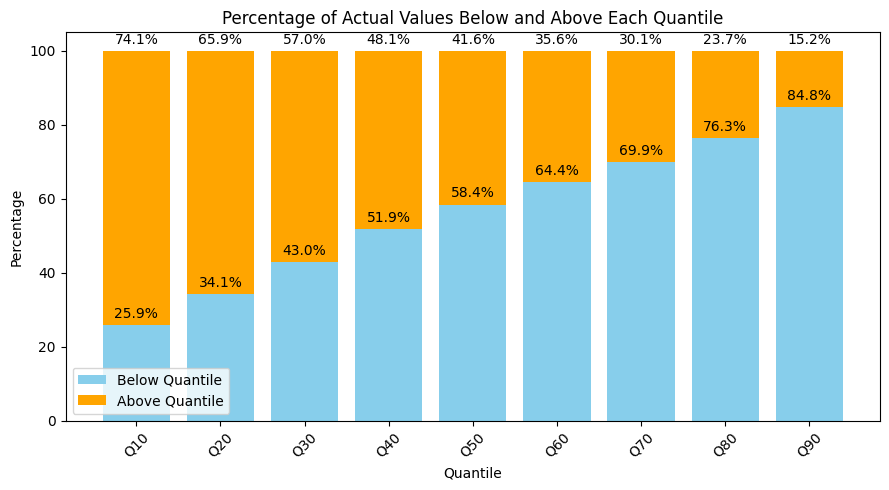

In [15]:
quantile_stats(quantile_predictions_df,'DA_Price')

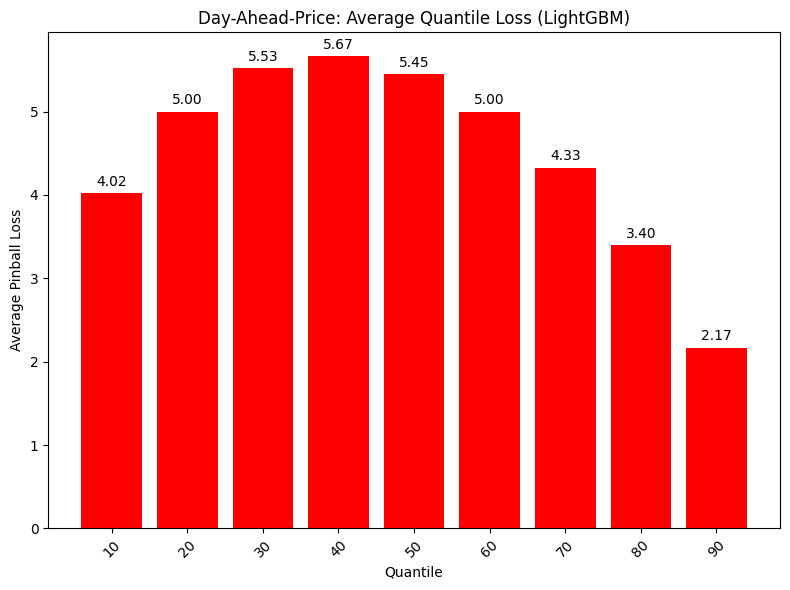

In [17]:
calculate_and_plot_average_quantile_loss(quantile_predictions_df, 'DA_Price', "Day-Ahead-Price: Average Quantile Loss (LightGBM)")